## 배터리 최적화(휴리스틱)

### 데이터 전처리

In [364]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(formatter={'float': '{:0.5f}'.format})

import pandas as pd


# .mat 파일 로드
data = loadmat('pvLoadPriceData_test.mat')

# 데이터 추출 예시
# MATLAB 파일 내에 있는 변수 이름을 정확히 알아야 합니다. time, cloudyDay, clearDay, loadData, costData
time = data['time'].flatten().reshape(-1, 1)

cloudyDay = data['cloudyDay'].flatten().reshape(-1, 1)

clearDay = data['clearDay'].flatten().reshape(-1, 1)

loadData = data['loadData'][:, 2].reshape(-1, 1)

costData = data['costData'].flatten().reshape(-1, 1)

print("자료형:", type(time), "차원" , time.shape, )
print("자료형:", type(cloudyDay), "차원" , cloudyDay.shape, )
print("자료형:", type(clearDay), "차원" , clearDay.shape, )
print("자료형:", type(loadData), "차원" , loadData.shape, )
print("자료형:", type(costData), "차원" , costData.shape, )



자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)
자료형: <class 'numpy.ndarray'> 차원 (228, 1)


### 데이터 처리

In [365]:
import numpy as np
import matlab.engine
import numpy as np

# Load Power Data from Existing PV array
# Assuming pvLoadPriceData is already loaded from file

# Set up Optimization Parameters
numDays = 1  # Number of consecutive days
FinalWeight = 1.0  # Final weight on energy storage
timeOptimize = 5  # Time step for optimization [min]

# Battery/PV parameters
panelArea = 2500
panelEff = 0.3

battEnergy = 2500 * 3.6e6
Einit = 0.5 * battEnergy
batteryMinMaxEmax = 0.8 * battEnergy
batteryMinMaxEmin = 0.2 * battEnergy
batteryMinMaxPmin = -400e3
batteryMinMaxPmax = 400e3

# Rescale data to align with desired time steps
stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))
cloudyPpv = panelArea * panelEff * np.tile(cloudyDay[2::stepAdjust], (numDays, 1))
clearPpv = panelArea * panelEff * np.tile(clearDay[1::stepAdjust], (numDays, 1))

# Adjust and Select Loading
loadSelect = 1
loadBase = 350e3
loadFluc = np.tile(loadData[1::stepAdjust], (numDays, 1)) + loadBase

# # Grid Price Values [$/kWh]
C = np.tile(costData[1::stepAdjust], (numDays, 1))

# Select Desired Data for Optimization
Ppv = clearPpv
# Ppv = cloudyPpv
Pload = loadFluc

# Setup Time Vectors
dt = timeOptimize * 60.0
N = numDays * (len(time[::stepAdjust]) - 1) * 1.0
tvec = np.arange(1, N + 1) * dt



/var/folders/4j/gkyhxcv573j8gxl2r220cymm0000gn/T/ipykernel_14855/375655470.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stepAdjust = int((timeOptimize * 60) / (time[1] - time[0]))


### 배터리 최적화(LP최적화)

In [366]:
def rule_based_control(Ppv, Pload, Ebatt, batteryMinMaxEmax, batteryMinMaxEmin, minSOC, maxSOC, Pmin, Pmax, time):
    Pgrid = np.zeros_like(Pload)  # 전력 그리드 초기화
    Pbatt = np.zeros_like(Pload)  # 배터리 전력 초기화
    Pcmd = np.zeros_like(Pload)   # 명령 전력 초기화

    for i in range(len(Pload)):
        # 배터리 충전량이 최소 SOC 이하인지 확인
        if Ebatt <= minSOC:
            # 부하 감축: 태양광 발전량이 부족하여 그리드로부터 전력을 가져옴
            Pgrid[i] = max(0, Pload[i] - Ppv[i])
        # 시간이 지정된 시간 범위 내에 있는지 확인
        elif (8 <= time[i] < 11 or 12 <= time[i] < 13 or 18 <= time[i] < 22) and minSOC < Ebatt < maxSOC:
            # 부하가 태양광보다 클 때
            if Pload[i] > Ppv[i]:
                if Pload[i] - Ppv[i] < Pmin:
                    # 충전: 배터리를 태양광 발전량으로 충전함
                    Pbatt[i] = min(Ppv[i] - Pload[i], batteryMinMaxEmax - Ebatt)
                    Ebatt += Pbatt[i]
                else:
                    # MPPT 끔: 배터리 충전량이 최대 충전 가능량을 초과함
                    Pbatt[i] = 0
                    Pcmd[i] = Pmin
            # 태양광이 부하보다 클 때
            elif Ppv[i] > Pload[i]:
                if Ppv[i] - Pload[i] < Pmax:
                    # 부하 감축: 태양광 발전량이 부하보다 많으므로 그리드에 전력을 공급하지 않음
                    Pgrid[i] = max(0, Pload[i] - Ppv[i])
                else:
                    # Pcmd를 Pmax로 설정: 배터리를 사용하여 그리드에 최대 전력을 공급함
                    Pcmd[i] = Pmax
            # Pcmd가 Pmin과 같을 때
            if Pcmd[i] == Pmin:
                # 방전: 배터리를 사용하여 그리드에 전력을 공급함
                Pbatt[i] = min(Ppv[i] - Pload[i], Ebatt - minSOC)
                Ebatt -= Pbatt[i]
        # 시간이 11-12, 13-18 또는 22시 이후인 경우
        elif (11 <= time[i] < 12 or 13 <= time[i] < 18 or time[i] >= 22):
            # 피크 시간: 그리드에 최대 전력을 공급함
            Pcmd[i] = Pmax
        # 배터리 충전량이 최대 SOC 이상인 경우
        elif Ebatt >= maxSOC:
            # MPPT 끔: 배터리 충전량이 최대 충전 가능량을 초과함
            Pbatt[i] = 0
    
    return Pgrid, Pbatt, Pcmd

# Usage
Pgrid, Pbatt , Pcmd= rule_based_control(Ppv, Pload, Einit, batteryMinMaxEmax, batteryMinMaxEmin, batteryMinMaxEmax, batteryMinMaxEmin, batteryMinMaxPmin, batteryMinMaxPmax, time)


### 그래프 출력

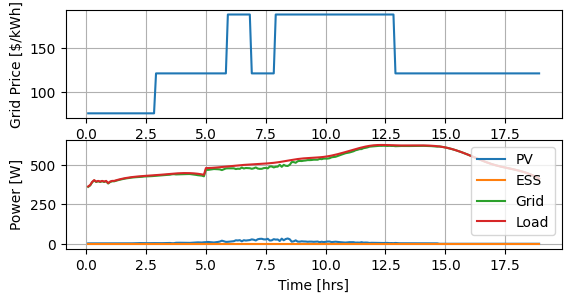

In [367]:
import matplotlib.pyplot as plt

thour = tvec / 3600

Ppv = np.array(Ppv)
Pload = np.array(Pload)


plt.subplot(3, 1, 2)
# Assuming C is grid price
plt.plot(thour, C)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Grid Price [$/kWh]')

plt.subplot(3, 1, 3)
# Assuming Ppv, Pbatt, Pgrid, Pload are obtained from battSolarOptimize
plt.plot(thour, Ppv / 1e3, thour, Pbatt / 1e3, thour, Pgrid / 1e3, thour, Pload / 1e3)
plt.grid(True)
plt.legend(['PV', 'ESS', 'Grid', 'Load'])
plt.xlabel('Time [hrs]')
plt.ylabel('Power [W]')

plt.show()


### 비용 계산

In [368]:
cumulativeCost = np.cumsum(Pgrid * (dt / 3600) * C)

Text(0, 0.5, 'Cost[cent-kwh]')

<Figure size 640x480 with 0 Axes>

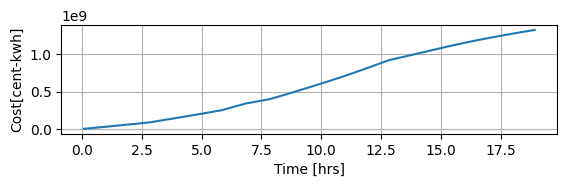

In [369]:
plt.figure()

plt.figure()
plt.subplot(3, 1, 1)
# Assuming Ebatt, Pbatt, Pgrid are obtained from battSolarOptimize
plt.plot(thour, cumulativeCost)
plt.grid(True)
plt.xlabel('Time [hrs]')
plt.ylabel('Cost[cent-kwh]')

In [371]:
cumulativeCost[-1] * 10e-6

13288.610841594564